In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import linregress

**Analysis**
------------
In this section we start the core of our analysis separate from discovery. While the discovery section is more about finding out what is in the data, the analysis section is about what we can do with the data. We start back again with our raw data and look to try and arrive at some conclusions.

In [2]:
# Combine all weather data into a single DataFrame
weather_data = pd.concat([pd.read_csv(f'data/weather_data_{year}.csv') for year in range(1950, 2024)])

In [3]:
# GDD calculation function
def calculate_gdd(df, base_temp=50, upper_temp=86):
    """
    Calculate Growing Degree Days (GDD) for corn.
    """
    df['TMAX'] = df['TMAX'].clip(lower=base_temp, upper=upper_temp)
    df['TMIN'] = df['TMIN'].clip(lower=base_temp)
    df['TAVG'] = (df['TMAX'] + df['TMIN']) / 2
    df['GDD'] = df['TAVG'] - base_temp
    return df

In [4]:
# Calculate GDD for each day
weather_data = calculate_gdd(weather_data)
weather_data

,date,TMAX,TMIN,PRCP,state_ansi,county_ansi,TAVG,GDD
0,1950-05-15,50.333333,50.000000,0.000000,26,3.0,50.166667,0.166667
1,1950-05-16,50.000000,50.000000,0.000000,26,3.0,50.000000,0.000000
2,1950-05-17,54.333333,50.000000,0.000000,26,3.0,52.166667,2.166667
3,1950-05-18,58.333333,50.000000,0.000000,26,3.0,54.166667,4.166667
4,1950-05-19,72.666667,50.000000,0.000000,26,3.0,61.333333,11.333333
...,...,...,...,...,...,...,...,...
8752,2023-07-17,NaN,NaN,0.148785,26,NaN,NaN,NaN
8753,2023-08-16,76.476744,53.632184,0.093815,26,NaN,65.054464,15.054464
8754,2023-08-17,NaN,NaN,0.161421,26,NaN,NaN,NaN
8755,2023-09-16,71.023392,50.000000,0.021863,26,NaN,60.511696,10.511696


For the analysis, a function is created that we can send a usda dataframe, provide the start and end dates, and determine whether or not we want to include "other counties". I will focus on year, county_name, county_ansi, and Value.

In [5]:
# Convert 'date' to datetime if it's not already
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Extract year and month
weather_data['year'] = weather_data['date'].dt.year
weather_data['month'] = weather_data['date'].dt.month

# Aggregate GDD by county and year
gdd_annual = weather_data.groupby(['state_ansi', 'county_ansi', 'year'])['GDD'].sum().reset_index()
gdd_annual


,state_ansi,county_ansi,year,GDD
0,26,1.0,1950,1837.50
1,26,1.0,1951,1840.50
2,26,1.0,1952,2111.50
3,26,1.0,1953,2044.00
4,26,1.0,1954,1967.50
...,...,...,...,...
4813,26,165.0,2015,2149.50
4814,26,165.0,2016,2419.00
4815,26,165.0,2020,2273.75
4816,26,165.0,2021,2396.00


In [6]:
# Combine all USDA data into a single DataFrame usda_data
usda_data = pd.concat([pd.read_csv(f'data/usda_data_{year}.csv') for year in range(1950, 2024)])

In [7]:
# I added some lines to clean the data, most files are fine but I am looking for the 'YIELD' data and skipping any suppressed data

# Filter for the relevant data (e.g., 'YIELD' in 'statisticcat_desc')
corn_data = usda_data[usda_data['statisticcat_desc'] == 'YIELD']

# Convert 'Value' to numeric, removing any commas or missing values
corn_data['Value'] = corn_data['Value'].replace(',', '', regex=True)
corn_data = corn_data[corn_data['Value'] != '(D)']  # Remove suppressed data
corn_data['Value'] = pd.to_numeric(corn_data['Value'])

# Select relevant columns
corn_data = corn_data[['state_ansi', 'county_ansi', 'year', 'Value', 'county_name']]


In [8]:
# Merge the GDD and corn yield data to make a single DataFrame

# Merge on 'state_ansi', 'county_ansi', and 'year'
merged_data = pd.merge(gdd_annual, corn_data, on=['state_ansi', 'county_ansi', 'year'])
# Remove entries with zero or NaN yields
merged_data = merged_data[merged_data['Value'] > 0]
# Remove entries with zero or NaN yields
merged_data = merged_data[merged_data['GDD'] > 0]



In [9]:
merged_data['Value'].describe()

count    4676.000000
mean       89.394718
std        38.837053
min        13.300000
25%        59.900000
50%        82.650000
75%       116.000000
max       213.000000
Name: Value, dtype: float64

In [10]:
merged_data['GDD'].describe()

count    4676.000000
mean     2293.160737
std       358.081588
min        73.500000
25%      2092.375000
50%      2332.875000
75%      2539.291667
max      3302.516667
Name: GDD, dtype: float64

**Visualize Data Distribution**
-------------------------------
Plot boxplots to visualize the distribution of GDD and corn yield.

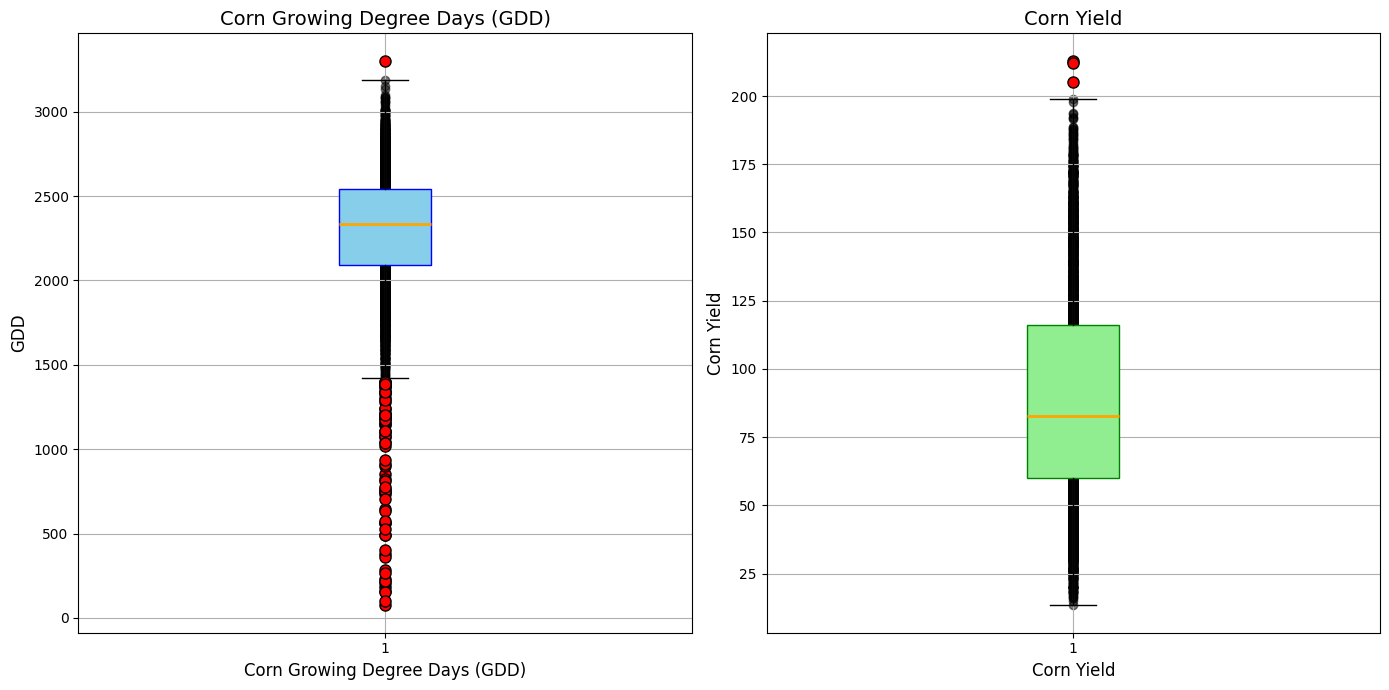

In [11]:
# Create a figure with subplots for side-by-side comparison
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Plot for 'GDD'
axs[0].boxplot(merged_data['GDD'], patch_artist=True,
               boxprops=dict(facecolor='skyblue', color='blue'),
               flierprops=dict(marker='o', markerfacecolor='red', markersize=8, linestyle='none'),
               medianprops=dict(color='orange', linewidth=2))
axs[0].set_title('Corn Growing Degree Days (GDD)', fontsize=14)
axs[0].set_ylabel('GDD', fontsize=12)
axs[0].set_xlabel('Corn Growing Degree Days (GDD)', fontsize=12)
axs[0].grid(True)

# Overlay data points
axs[0].scatter(np.ones(len(merged_data['GDD'])), merged_data['GDD'], color='black', alpha=0.5)

# Plot for Corn
axs[1].boxplot(merged_data['Value'], patch_artist=True,
               boxprops=dict(facecolor='lightgreen', color='green'),
               flierprops=dict(marker='o', markerfacecolor='red', markersize=8, linestyle='none'),
               medianprops=dict(color='orange', linewidth=2))
axs[1].set_title('Corn Yield', fontsize=14)
axs[1].set_ylabel('Corn Yield', fontsize=12)
axs[1].set_xlabel('Corn Yield', fontsize=12)
axs[1].grid(True)

# Overlay data points
axs[1].scatter(np.ones(len(merged_data['Value'])), merged_data['Value'], color='black', alpha=0.5)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


**Remove Outliers**
-------------------
Identify and remove outliers using the Interquartile Range (IQR) method.

In [12]:
# Calculate IQR for 'GDD' and 'Value' columns to identify outliers
Q1_GDD = merged_data['GDD'].quantile(0.25)
Q3_GDD = merged_data['GDD'].quantile(0.75)
IQR_GDD = Q3_GDD - Q1_GDD

Q1_Value = merged_data['Value'].quantile(0.25)
Q3_Value = merged_data['Value'].quantile(0.75)
IQR_Value = Q3_Value - Q1_Value

# Define bounds for outliers in 'GDD' and 'Value'
lower_bound_GDD = Q1_GDD - 1.5 * IQR_GDD
upper_bound_GDD = Q3_GDD + 1.5 * IQR_GDD

lower_bound_Value = Q1_Value - 1.5 * IQR_Value
upper_bound_Value = Q3_Value + 1.5 * IQR_Value

# Filter out the outliers
merged_data = merged_data[
    (merged_data['GDD'] >= lower_bound_GDD) & (merged_data['GDD'] <= upper_bound_GDD) &
    (merged_data['Value'] >= lower_bound_Value) & (merged_data['Value'] <= upper_bound_Value)
]



**Re-examine the Data**
-----------------------
Check the statistical summary after removing outliers.

In [13]:
merged_data['Value'].describe()

count    4602.000000
mean       89.259279
std        38.691314
min        13.300000
25%        59.625000
50%        82.550000
75%       116.000000
max       198.800000
Name: Value, dtype: float64

In [14]:
merged_data['GDD'].describe()

count    4602.000000
mean     2313.939716
std       312.155013
min      1423.833333
25%      2106.000000
50%      2338.000000
75%      2543.250000
max      3186.666667
Name: GDD, dtype: float64

In [15]:
# Dump merged_data to csv for sanity check
merged_data.to_csv('merged_data.csv', index=False)

**Visualize Correlation Between GDD and Corn Yield**
----------------------------------------------------
Create a scatter plot to visualize the correlation, with a color gradient showing time progression.

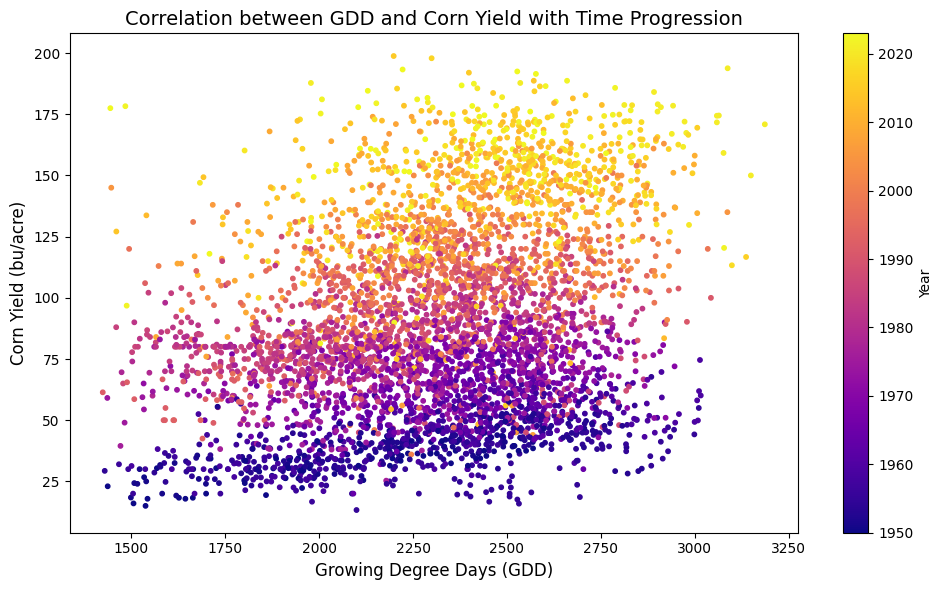

In [16]:
# Create a scatter plot with color gradient for time progression
plt.figure(figsize=(10, 6))

# Scatter plot with color mapped to 'year' and a plasma colormap for better color representation
scatter = plt.scatter(x=merged_data['GDD'], y=merged_data['Value'], c=merged_data['year'], cmap='plasma', s=10)

# Add colorbar to show year progression
cbar = plt.colorbar(scatter)
cbar.set_label('Year')

# Set titles and labels
plt.title('Correlation between GDD and Corn Yield with Time Progression', fontsize=14)
plt.xlabel('Growing Degree Days (GDD)', fontsize=12)
plt.ylabel('Corn Yield (bu/acre)', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


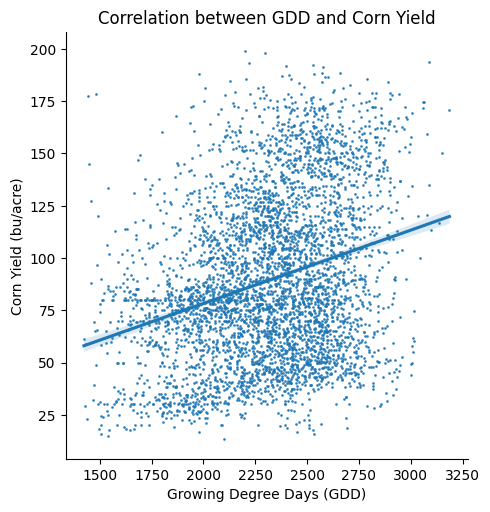

In [17]:
# Scatter plot of GDD vs. corn yield
sns.lmplot(x='GDD', y='Value', data=merged_data, scatter_kws={'s': 1})
plt.title('Correlation between GDD and Corn Yield')
plt.xlabel('Growing Degree Days (GDD)')
plt.ylabel('Corn Yield (bu/acre)')
plt.show()

**Analyze Precipitation Data**
------------------------------
We will analyze the correlation between total precipitation (PRCP) and corn yield.

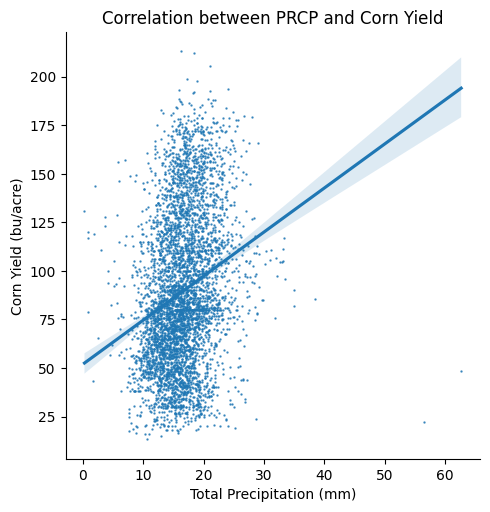

In [18]:
# Make the same chart with PRCP instead of GDD

# Calculate total precipitation for the growing season
weather_data['PRCP'] = weather_data['PRCP'].clip(lower=0)
prcp_annual = weather_data.groupby(['state_ansi', 'county_ansi', 'year'])['PRCP'].sum().reset_index()

# Merge on 'state_ansi', 'county_ansi', and 'year'
merged_data_prcp = pd.merge(prcp_annual, corn_data, on=['state_ansi', 'county_ansi', 'year'])
# Remove entries with zero or NaN yields
merged_data_prcp = merged_data_prcp[merged_data_prcp['Value'] > 0]
# Remove entries with zero or NaN yields
merged_data_prcp = merged_data_prcp[merged_data_prcp['PRCP'] > 0]

# Scatter plot with regression line
sns.lmplot(x='PRCP', y='Value', data=merged_data_prcp, scatter_kws={'s': 0.5})
plt.title('Correlation between PRCP and Corn Yield')
plt.xlabel('Total Precipitation (mm)')
plt.ylabel('Corn Yield (bu/acre)')
plt.show()


Given the data was similar to the GDD data, we dind't feel it was necessary to include the analysis of the precipitation data.

In [19]:
# Add precipitation data to the merged dataframe
#prcp_annual = weather_data.groupby(['state_ansi', 'county_ansi', 'year'])['PRCP'].sum().reset_index()
#merged_data = pd.merge(merged_data, prcp_annual, on=['state_ansi', 'county_ansi', 'year'])


**Perform Linear Regression Analysis**
--------------------------------------
We will perform an Ordinary Least Squares (OLS) regression to quantify the relationship between GDD and corn yield.

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     400.2
Date:                Tue, 08 Oct 2024   Prob (F-statistic):           1.92e-85
Time:                        01:44:33   Log-Likelihood:                -23161.
No. Observations:                4602   AIC:                         4.633e+04
Df Residuals:                    4600   BIC:                         4.634e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1149      4.093      1.983      0.0

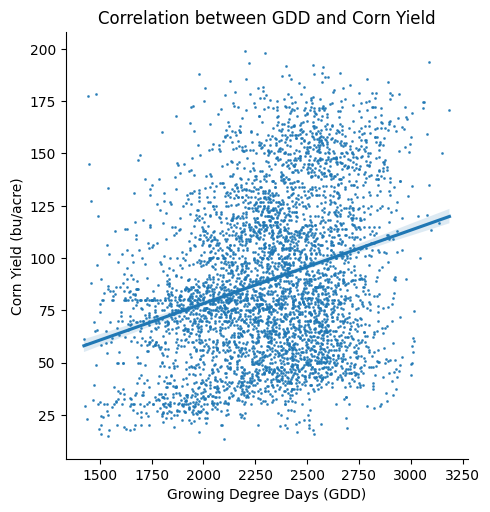

In [20]:
# Step 1: Prepare the data for OLS (adding a constant for intercept)
X = sm.add_constant(merged_data['GDD'])  # Independent variable (GDD) with a constant
y = merged_data['Value']  # Dependent variable (Corn Yield)

# Step 2: Fit the OLS model
ols_model = sm.OLS(y, X).fit()

# Step 3: Print out the summary of the regression
print(ols_model.summary())

# Step 4: Plot the scatter plot with regression line (optional, already in your code)
sns.lmplot(x='GDD', y='Value', data=merged_data, scatter_kws={'s': 1})
plt.title('Correlation between GDD and Corn Yield')
plt.xlabel('Growing Degree Days (GDD)')
plt.ylabel('Corn Yield (bu/acre)')
plt.show()


**Multiple Linear Regression**
------------------------------
Include both GDD and Year as independent variables to see if time has an effect on yield.

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     9557.
Date:                Tue, 08 Oct 2024   Prob (F-statistic):               0.00
Time:                        01:44:34   Log-Likelihood:                -19579.
No. Observations:                4602   AIC:                         3.916e+04
Df Residuals:                    4599   BIC:                         3.918e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3099.5227     23.759   -130.455      0.0

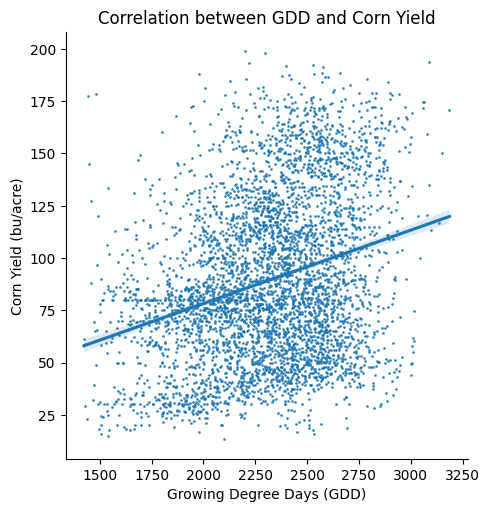

In [21]:
# Step 1: Prepare the data for OLS (adding a constant for intercept)
X = merged_data[['GDD', 'year']]  # Independent variables (GDD and Year)
X = sm.add_constant(X)  # Add constant for the intercept
y = merged_data['Value']  # Dependent variable (Corn Yield)

# Step 2: Fit the OLS model
ols_model = sm.OLS(y, X).fit()

# Step 3: Print out the summary of the regression
print(ols_model.summary())

# Step 4: Plot the scatter plot with regression line for GDD (optional)
sns.lmplot(x='GDD', y='Value', data=merged_data, scatter_kws={'s': 1})
plt.title('Correlation between GDD and Corn Yield')
plt.xlabel('Growing Degree Days (GDD)')
plt.ylabel('Corn Yield (bu/acre)')
plt.show()


In [22]:
# Define independent variables and dependent variable
#X = merged_data[['GDD', 'PRCP']]
X = merged_data[['Value']]
y = merged_data['GDD']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    GDD   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     400.2
Date:                Tue, 08 Oct 2024   Prob (F-statistic):           1.92e-85
Time:                        01:44:35   Log-Likelihood:                -32769.
No. Observations:                4602   AIC:                         6.554e+04
Df Residuals:                    4600   BIC:                         6.556e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2110.2010     11.099    190.120      0.0

**Ranking**
------------
We determined a ranking of the counties based on a number of factors and will use a normalized score to rank the counties. in the end.

- Highest Average Yield
- Consistency Above State Average
- Highest GDD
- Low Variability

In [23]:
# Calculate the average yield per county over the entire period
average_yield = merged_data.groupby('county_name')['Value'].mean().reset_index()

# Sort counties by average yield in descending order
average_yield_sorted = average_yield.sort_values(by='Value', ascending=False)

# Top 10 counties
print("Top 10 Counties by Average Corn Yield:")
print(average_yield_sorted.head(10))


Top 10 Counties by Average Corn Yield:
   county_name       Value
43     LENAWEE  112.790278
55      MONROE  112.680822
29       HURON  111.522222
76     TUSCOLA  108.340278
70     SAGINAW  107.410959
71     SANILAC  106.361194
7          BAY  106.347143
30      INGHAM  103.489041
53     MIDLAND  103.487500
26     GRATIOT  103.316176


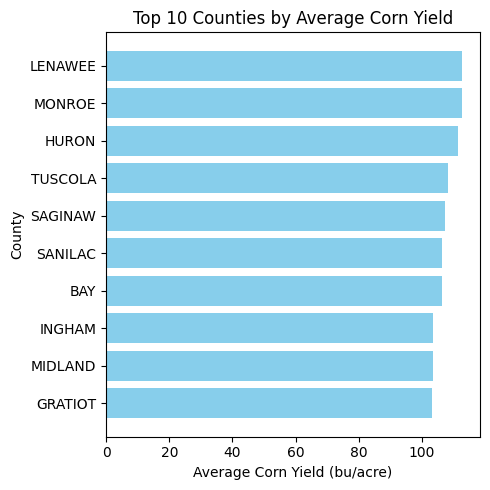

In [24]:
# Horizontal bar plot of average yields for top 10 counties in reverse order
plt.figure(figsize=(5, 5))
plt.barh(average_yield_sorted['county_name'].head(10)[::-1], average_yield_sorted['Value'].head(10)[::-1], color='skyblue')
plt.ylabel('County')
plt.xlabel('Average Corn Yield (bu/acre)')
plt.title('Top 10 Counties by Average Corn Yield')
plt.tight_layout()
plt.show()


In [25]:
# I was wondering if we pick the best based how consistent are they in beating the state average

# Calculate the state average yield for each year
state_average_yield = merged_data.groupby('year')['Value'].mean().reset_index(name='state_avg_yield')

# Merge state average back into merged_data
merged_data_with_state_avg = pd.merge(merged_data, state_average_yield, on='year')

# Create a flag for whether the county's yield is above the state average each year
merged_data_with_state_avg['above_state_avg'] = merged_data_with_state_avg['Value'] > merged_data_with_state_avg['state_avg_yield']

# Calculate the percentage of years each county was above the state average
county_performance = merged_data_with_state_avg.groupby('county_name')['above_state_avg'].mean().reset_index()

# Convert to percentage
county_performance['percent_above_state_avg'] = county_performance['above_state_avg'] * 100

# Sort counties by percentage in descending order
county_performance_sorted = county_performance.sort_values(by='percent_above_state_avg', ascending=False)

# Display the top 10 counties
print("Top 10 Counties by Consistency in Exceeding State Average Yield:")
print(county_performance_sorted.head(10))


Top 10 Counties by Consistency in Exceeding State Average Yield:
   county_name  above_state_avg  percent_above_state_avg
70     SAGINAW         0.986301                98.630137
76     TUSCOLA         0.972222                97.222222
7          BAY         0.971429                97.142857
55      MONROE         0.958904                95.890411
26     GRATIOT         0.955882                95.588235
29       HURON         0.930556                93.055556
43     LENAWEE         0.930556                93.055556
20       EATON         0.888889                88.888889
31       IONIA         0.885246                88.524590
71     SANILAC         0.880597                88.059701


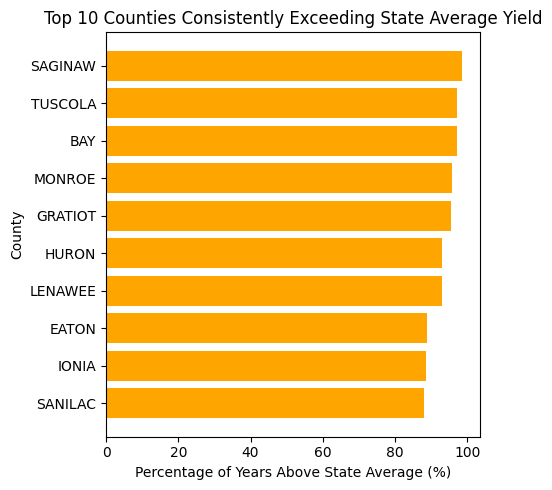

In [26]:
# Horizontal bar plot of top 10 counties by percentage of years above state average in reverse order
plt.figure(figsize=(5, 5))
plt.barh(county_performance_sorted['county_name'].head(10)[::-1], county_performance_sorted['percent_above_state_avg'].head(10)[::-1], color='orange')
plt.ylabel('County')
plt.xlabel('Percentage of Years Above State Average (%)')
plt.title('Top 10 Counties Consistently Exceeding State Average Yield')
plt.tight_layout()
plt.show()


In [27]:
# What about finding the best improved county over time wiht slope

# Prepare a DataFrame to store slopes
county_slopes = []

for county in merged_data['county_name'].unique():
    county_data = merged_data[merged_data['county_name'] == county]
    if len(county_data['year'].unique()) > 1:  # Ensure there's enough data
        slope, intercept, r_value, p_value, std_err = linregress(county_data['year'], county_data['Value'])
        county_slopes.append({'county_name': county, 'slope': slope, 'p_value': p_value})
    else:
        county_slopes.append({'county_name': county, 'slope': np.nan, 'p_value': np.nan})

# Convert to DataFrame
slopes_df = pd.DataFrame(county_slopes)

# Remove counties with NaN slopes
slopes_df.dropna(subset=['slope'], inplace=True)

# Sort counties by slope
slopes_df_sorted = slopes_df.sort_values(by='slope', ascending=False)

print("Top 10 Counties by Yield Improvement Over Time:")
print(slopes_df_sorted.head(10))


Top 10 Counties by Yield Improvement Over Time:
   county_name     slope       p_value
73     SANILAC  2.040895  6.465954e-44
29       HURON  2.012536  1.084400e-39
53     MIDLAND  1.920669  1.193659e-43
76     TUSCOLA  1.892947  2.415209e-39
31       IONIA  1.880289  2.765833e-33
28    HOUGHTON  1.860489  7.054970e-11
7          BAY  1.839049  5.851983e-38
2      ALLEGAN  1.836926  1.833743e-34
9      BERRIEN  1.821258  1.095833e-35
47      MACOMB  1.819218  1.573143e-41


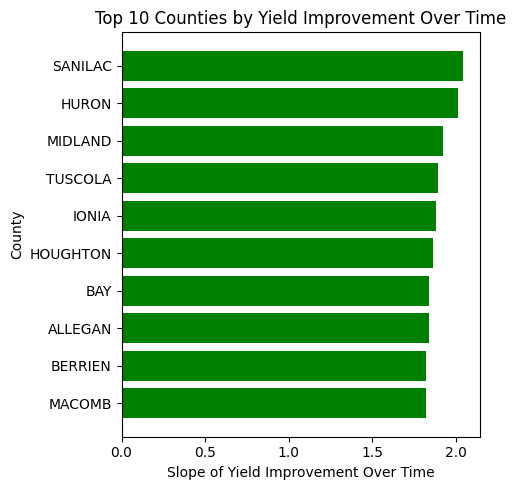

In [28]:
# Horizontal bar plot of top 10 counties by yield improvement over time (slope)
plt.figure(figsize=(5, 5))
plt.barh(slopes_df_sorted['county_name'].head(10)[::-1], slopes_df_sorted['slope'].head(10)[::-1], color='green')
plt.ylabel('County')
plt.xlabel('Slope of Yield Improvement Over Time')
plt.title('Top 10 Counties by Yield Improvement Over Time')
plt.tight_layout()
plt.show()


In [29]:
# Lets looks at the counties that have been the most consistent in their yield over time

# Calculate standard deviation of yield per county
yield_variability = merged_data.groupby('county_name')['Value'].std().reset_index(name='yield_std')

# Sort counties by yield_std in ascending order
yield_variability_sorted = yield_variability.sort_values(by='yield_std')

print("Top 10 Counties with Least Yield Variability:")
print(yield_variability_sorted.head(10))


Top 10 Counties with Least Yield Variability:
   county_name  yield_std
39    KEWEENAW  12.020815
5       BARAGA  18.176117
17    CRAWFORD  18.434486
37    KALKASKA  18.705415
33        IRON  20.029078
64     OSCEOLA  21.333992
49   MARQUETTE  22.110894
65      OSCODA  22.709543
15    CHIPPEWA  23.067726
24     GOGEBIC  24.020784


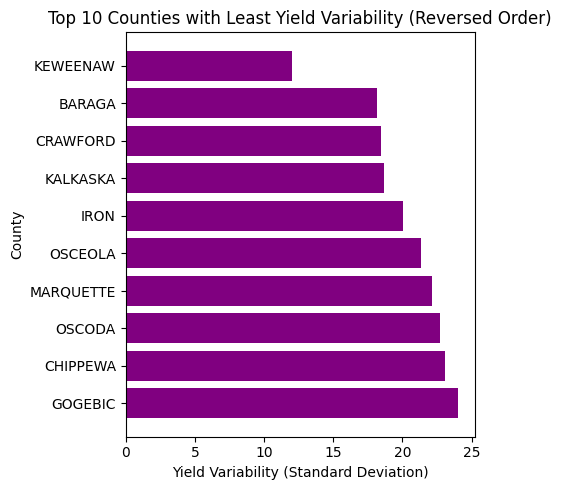

In [30]:
# Horizontal bar plot of top 10 counties with least yield variability (standard deviation)
plt.figure(figsize=(5, 5))
plt.barh(yield_variability_sorted['county_name'].head(10)[::-1], yield_variability_sorted['yield_std'].head(10)[::-1], color='purple')
plt.ylabel('County')
plt.xlabel('Yield Variability (Standard Deviation)')
plt.title('Top 10 Counties with Least Yield Variability (Reversed Order)')
plt.tight_layout()
plt.show()


In [31]:
# Lets look at the counties with the highest average gdd

# Calculate average GDD per county
avg_gdd_per_county = merged_data.groupby('county_name')['GDD'].mean().reset_index()

# Sort counties by average GDD in descending order
avg_gdd_per_county_sorted = avg_gdd_per_county.sort_values(by='GDD', ascending=False)

print("Top 10 Counties by Average Growing Degree Days:")
print(avg_gdd_per_county_sorted.head(10))


Top 10 Counties by Average Growing Degree Days:
   county_name          GDD
79       WAYNE  2747.299349
36   KALAMAZOO  2720.302817
55      MONROE  2653.339384
9      BERRIEN  2651.233696
78   WASHTENAW  2642.456407
75   ST JOSEPH  2622.190141
11     CALHOUN  2572.603881
43     LENAWEE  2569.042824
60     OAKLAND  2559.834505
12        CASS  2550.965278


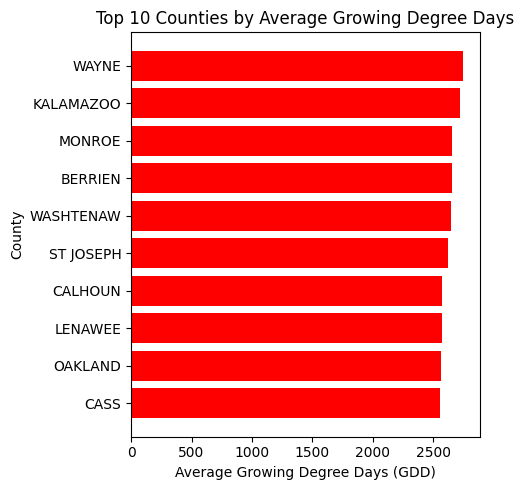

In [32]:
# Horizontal bar plot of top 10 counties by average GDD
plt.figure(figsize=(5, 5))
plt.barh(avg_gdd_per_county_sorted['county_name'].head(10)[::-1], avg_gdd_per_county_sorted['GDD'].head(10)[::-1], color='red')
plt.ylabel('County')
plt.xlabel('Average Growing Degree Days (GDD)')
plt.title('Top 10 Counties by Average Growing Degree Days')
plt.tight_layout()
plt.show()


In [33]:
# Use county_name to merge all the other DFs
county_metrics = average_yield[['county_name', 'Value']].merge(
    county_performance[['county_name', 'percent_above_state_avg']], on='county_name').merge(
    yield_variability[['county_name', 'yield_std']], on='county_name').merge(
    avg_gdd_per_county[['county_name', 'GDD']], on='county_name')

# Normalize the metrics
scaler = MinMaxScaler()

county_metrics[['avg_yield_norm', 'percent_above_avg_norm', 'yield_std_norm', 'avg_gdd_per_county']] = scaler.fit_transform(
    county_metrics[['Value', 'percent_above_state_avg', 'yield_std', 'GDD']])

# Invert yield_std_norm so that lower variability scores higher
county_metrics['yield_std_norm'] = 1 - county_metrics['yield_std_norm']

# I assigned weights to each metric but nothing scientific
# Should come back to this later
county_metrics['total_score'] = (
    county_metrics['avg_yield_norm'] * 0.4 +
    county_metrics['percent_above_avg_norm'] * 0.3 +
    county_metrics['yield_std_norm'] * 0.1 +
    county_metrics['avg_gdd_per_county'] * 0.1
)

# Sort counties by total_score
county_metrics_sorted = county_metrics.sort_values(by='total_score', ascending=False)

print("Top 10 Counties by Composite Score:")
print(county_metrics_sorted[['county_name', 'total_score']].head(10))


Top 10 Counties by Composite Score:
   county_name  total_score
55      MONROE     0.802234
43     LENAWEE     0.786522
70     SAGINAW     0.766055
76     TUSCOLA     0.754468
7          BAY     0.742867
26     GRATIOT     0.737789
29       HURON     0.733329
30      INGHAM     0.704419
20       EATON     0.700856
10      BRANCH     0.700355


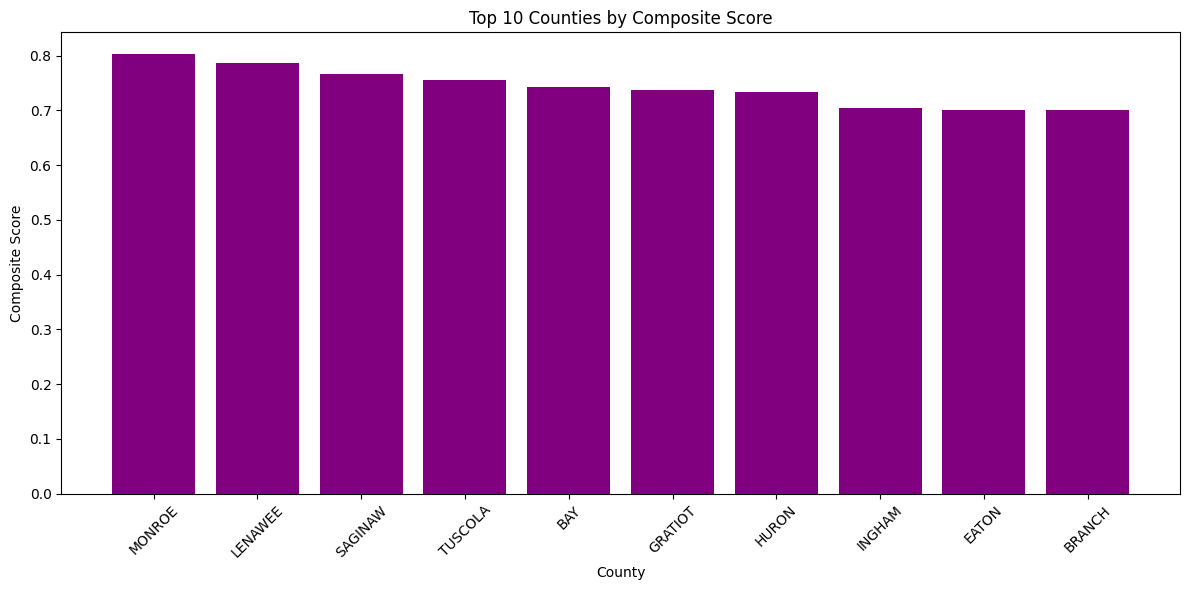

In [34]:
# Bar plot of top 10 counties by composite score
plt.figure(figsize=(12, 6))
plt.bar(county_metrics_sorted['county_name'].head(10), county_metrics_sorted['total_score'].head(10), color='purple')
plt.xticks(rotation=45)
plt.xlabel('County')
plt.ylabel('Composite Score')
plt.title('Top 10 Counties by Composite Score')
plt.tight_layout()
plt.show()


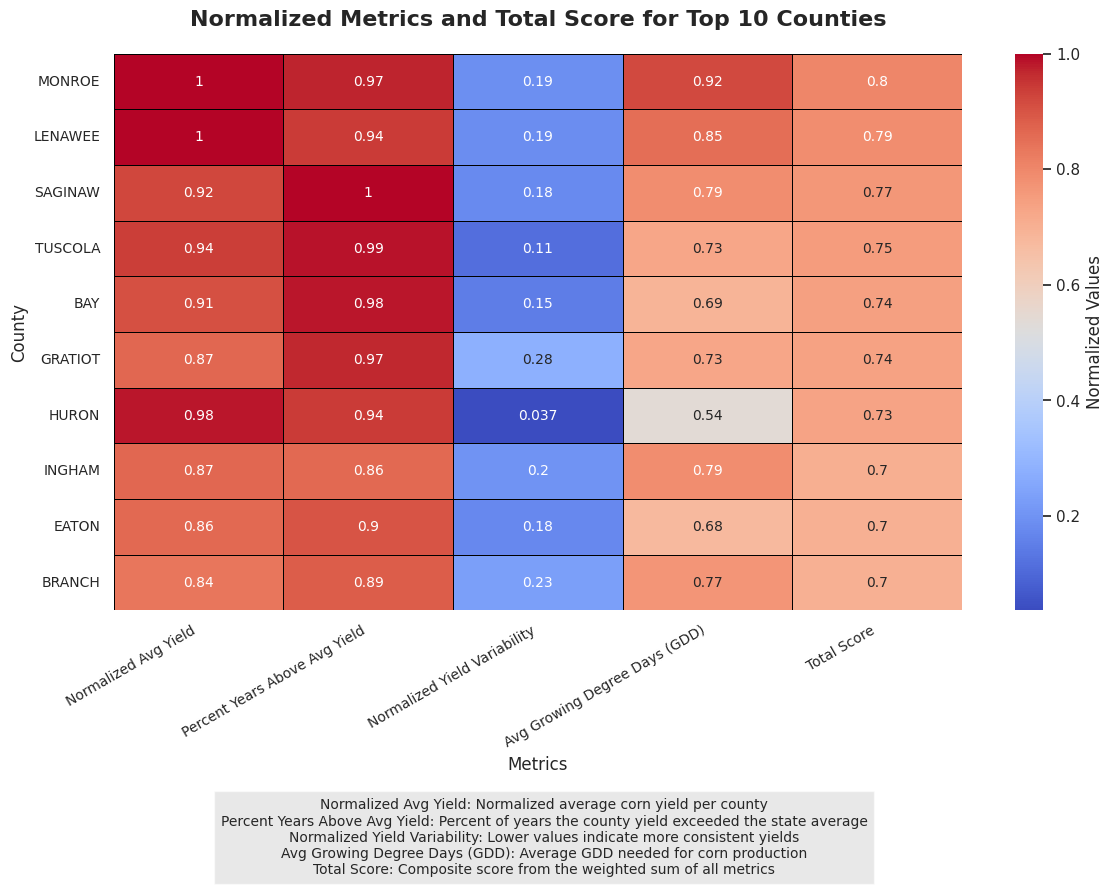

In [35]:
# Prepare data for heatmap
metrics_for_heatmap = county_metrics_sorted[['county_name', 'avg_yield_norm', 'percent_above_avg_norm', 'yield_std_norm', 'avg_gdd_per_county', 'total_score']].set_index('county_name')

# Rename the columns to make the metric names more readable
metrics_for_heatmap.rename(columns={
    'avg_yield_norm': 'Normalized Avg Yield',
    'percent_above_avg_norm': 'Percent Years Above Avg Yield',
    'yield_std_norm': 'Normalized Yield Variability',
    'avg_gdd_per_county': 'Avg Growing Degree Days (GDD)',
    'total_score': 'Total Score'
}, inplace=True)

# Set a larger and professional style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Plot heatmap with enhancements
heatmap = sns.heatmap(metrics_for_heatmap.head(10), 
                      annot=True, 
                      cmap='coolwarm',  # More polished colormap
                      linewidths=0.5,   # Add gridlines
                      linecolor='black', # Gridline color
                      annot_kws={"size": 10},  # Annotation text size
                      cbar_kws={'label': 'Normalized Values'})  # Label the color bar

# Enhance title and axis labels
plt.title('Normalized Metrics and Total Score for Top 10 Counties', fontsize=16, weight='bold', pad=20)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('County', fontsize=12)

# Add a descriptive legend for x-axis values
plt.figtext(0.46, -0.1,
            'Normalized Avg Yield: Normalized average corn yield per county\n'
            'Percent Years Above Avg Yield: Percent of years the county yield exceeded the state average\n'
            'Normalized Yield Variability: Lower values indicate more consistent yields\n'
            'Avg Growing Degree Days (GDD): Average GDD needed for corn production\n'
            'Total Score: Composite score from the weighted sum of all metrics',
            ha='center', fontsize=10, wrap=True, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

# Adjust layout for better spacing
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the heatmap
plt.show()
